In [4]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def rgb_to_ycocg_r(img):
    R = img[:, :, 0].astype(np.int32)
    G = img[:, :, 1].astype(np.int32)
    B = img[:, :, 2].astype(np.int32)

    # Forward transform (YCoCg-R)
    Co = R - B
    t  = B + (Co >> 1)
    Cg = G - t
    Y  = t + (Cg >> 1)

    return Y, Co, Cg


def normalize_channel(channel):
    ch_min = channel.min()
    ch_max = channel.max()

    # Avoid division by zero
    if ch_max == ch_min:
        return np.zeros_like(channel, dtype=np.uint8)

    # Scale to 0–255
    norm = (channel - ch_min) * (255.0 / (ch_max - ch_min))
    return norm.astype(np.uint8)


def show_image(title, img, cmap=None):
    plt.figure(figsize=(5,5))
    plt.title(title)
    if cmap is not None:
        plt.imshow(img, cmap=cmap)
    else:
        plt.imshow(img)
    plt.axis("off")
    plt.show()


In [5]:
def false_color_co(Co):
    """Map Co to orange-blue color."""
    norm = normalize_channel(Co)
    rgb = np.zeros((norm.shape[0], norm.shape[1], 3), dtype=np.uint8)
    rgb[:, :, 0] = norm          # R
    rgb[:, :, 1] = 128           # fixed mid green
    rgb[:, :, 2] = 255 - norm    # B (complement)
    return rgb

def false_color_cg(Cg):
    """Map Cg to green-magenta color."""
    norm = normalize_channel(Cg)
    rgb = np.zeros((norm.shape[0], norm.shape[1], 3), dtype=np.uint8)
    rgb[:, :, 0] = 255 - norm    # R (complement)
    rgb[:, :, 1] = norm          # G
    rgb[:, :, 2] = 255 - norm    # B (magenta mix)
    return rgb

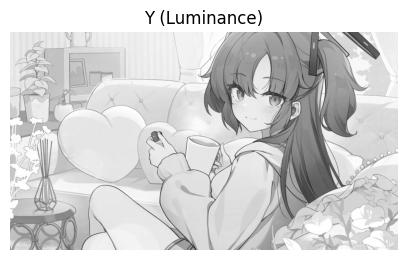

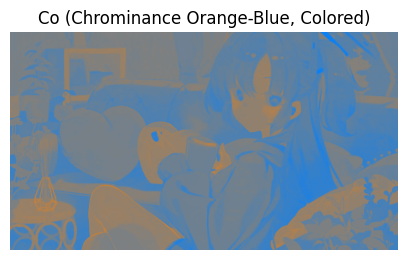

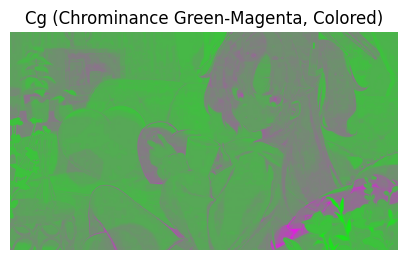

Berhasil disimpan: Y.png, Co.png, Cg.png


In [6]:
dir = "img/"
input_path = dir + "mybini.png"

img = Image.open(input_path).convert("RGB")
img_np = np.array(img)

Ye, Co, Cg = rgb_to_ycocg_r(img_np)

# Normalize grayscale (untuk tampilan asli)
Y_norm  = normalize_channel(Ye)
Co_norm = normalize_channel(Co)
Cg_norm = normalize_channel(Cg)

# False-color visualization
Co_color = false_color_co(Co)
Cg_color = false_color_cg(Cg)

# ===== SHOW IMAGES =====
show_image("Y (Luminance)", Y_norm, cmap='gray')
show_image("Co (Chrominance Orange-Blue, Colored)", Co_color)
show_image("Cg (Chrominance Green-Magenta, Colored)", Cg_color)

# ===== SAVE OUTPUT =====
Image.fromarray(Y_norm).save(dir + "Y.png")
Image.fromarray(Co_color).save(dir + "Co.png")
Image.fromarray(Cg_color).save(dir + "Cg.png")

print("Berhasil disimpan: Y.png, Co.png, Cg.png")

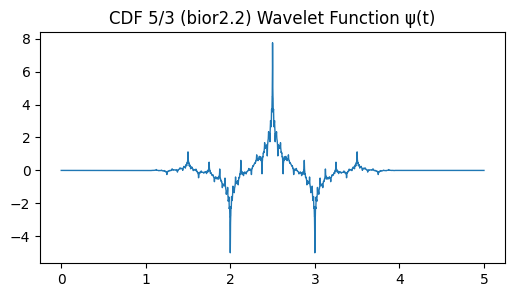

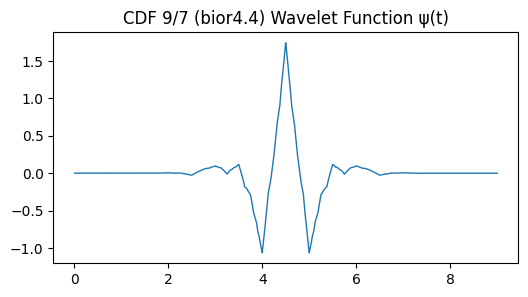

In [6]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

w = pywt.Wavelet('bior2.2')

dir = "img/"
# wavefun untuk bior menghasilkan 5 nilai
phi, psi, phi_r, psi_r, x = w.wavefun(level=10)

plt.figure(figsize=(6,3))
plt.plot(x, psi, linewidth=1.0)
plt.grid(False)
plt.savefig(dir + "CDF 5_3 (bior2.2).png")
plt.title("CDF 5/3 (bior2.2) Wavelet Function ψ(t)")
plt.show()


# Wavelet CDF 9/7
w = pywt.Wavelet('bior4.4')

# wavefun() mengembalikan 5 nilai untuk biorthogonal wavelets
phi, psi, phi_r, psi_r, x = w.wavefun(level=10)

# Plot wavelet function ψ(t)
plt.figure(figsize=(6,3))
plt.plot(x, psi, linewidth=1.0)
plt.grid(False)
plt.savefig(dir + "CDF 9_7 (bior4.4).png")
plt.title("CDF 9/7 (bior4.4) Wavelet Function ψ(t)")
plt.show()


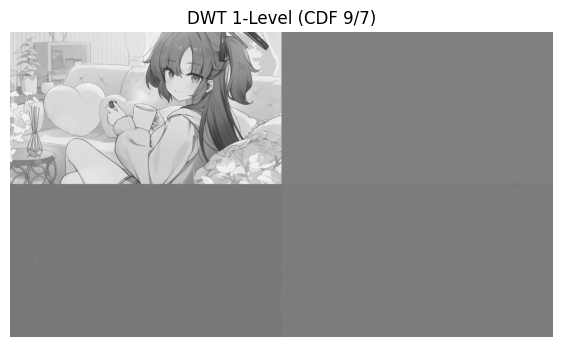

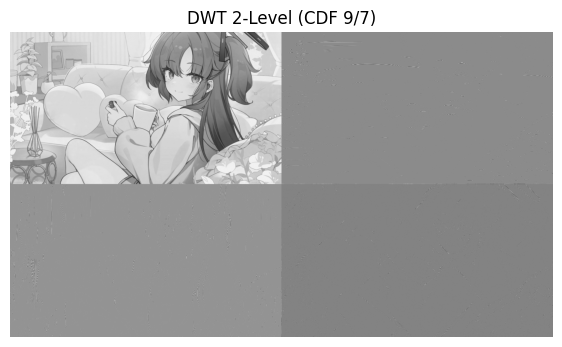

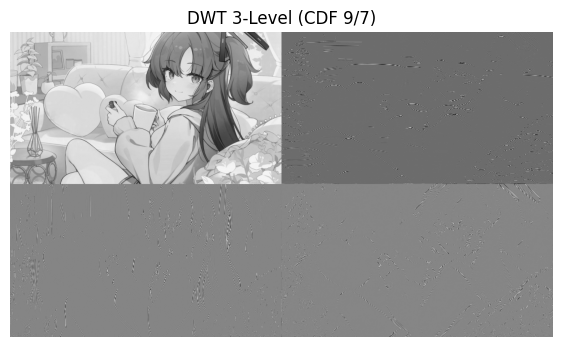

In [ ]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


# ================================
# 1. Load Image (grayscale)
# ================================
dir = "img/"
img = Image.open(dir + "mybini.png").convert("L")
img = np.array(img, dtype=np.float32)


# ================================
# Helper: Normalize
# ================================
def norm(b):
    mn, mx = b.min(), b.max()
    if mx - mn == 0:
        return np.zeros_like(b)
    return (b - mn) / (mx - mn)


# ================================
# Helper: Build Mosaic from subbands
# ================================
def build_mosaic(LL, LH, HL, HH):
    h, w = LL.shape
    canvas = np.zeros((h*2, w*2), dtype=np.float32)

    canvas[0:h, 0:w]   = norm(LL)
    canvas[0:h, w:2*w] = norm(HL)
    canvas[h:2*h, 0:w] = norm(LH)
    canvas[h:2*h, w:2*w] = norm(HH)

    return canvas


# ================================
# 2. Compute DWT level 1, 2, 3
# ================================
wave = "bior4.4"   # CDF 9/7
cA1, (cH1, cV1, cD1) = pywt.dwt2(img, wave, mode='periodization')
cA2, (cH2, cV2, cD2) = pywt.dwt2(cA1, wave, mode='periodization')
cA3, (cH3, cV3, cD3) = pywt.dwt2(cA2, wave, mode='periodization')


# ================================
# 3. Build mosaics for each level
# ================================
mosaic1 = build_mosaic(cA1, cV1, cH1, cD1)
mosaic2 = build_mosaic(cA2, cV2, cH2, cD2)
mosaic3 = build_mosaic(cA3, cV3, cH3, cD3)

# ================================
# 4. Display the 3 mosaics
# ================================
plt.figure(figsize=(7,7))
plt.imshow(mosaic1, cmap='gray')
plt.title("DWT 1-Level (CDF 9/7)")
plt.axis('off')
plt.show()

plt.figure(figsize=(7,7))
plt.imshow(mosaic2, cmap='gray')
plt.title("DWT 2-Level (CDF 9/7)")
plt.axis('off')
plt.show()

plt.figure(figsize=(7,7))
plt.imshow(mosaic3, cmap='gray')
plt.title("DWT 3-Level (CDF 9/7)")
plt.axis('off')
plt.show()


In [ ]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
import os
import pandas as pd

def mse(img1, img2):
    return np.mean((img1 - img2) ** 2)

def psnr(img1, img2):
    m = mse(img1, img2)
    if m == 0:
        return 100
    return 20 * np.log10(255.0 / np.sqrt(m))

# =============================
# Load image
# =============================
dir = "img/"
img = cv2.imread(os.path.join(dir, "seiza ni naretara.png"), cv2.IMREAD_GRAYSCALE)
h, w = img.shape

# =============================
# Parameter JPEG dan JPEG2000
# =============================
jpeg_q = [10, 20, 40, 60, 80, 90]
jp2_r  = [100, 50, 20, 10, 5, 2]  # semakin kecil → kualitas lebih bagus

records = []

# =============================
# JPEG Tests
# =============================
for q in jpeg_q:
    out = f"tmp_jpeg_{q}.jpg"
    cv2.imwrite(out, img, [cv2.IMWRITE_JPEG_QUALITY, q])
    comp = cv2.imread(out, cv2.IMREAD_GRAYSCALE)
    
    file_size = os.path.getsize(out)
    rate = (file_size * 8) / (h * w)  # bits per pixel

    records.append({
        "Method": "JPEG",
        "Param": q,
        "Rate (bpp)": rate,
        "MSE": mse(img, comp),
        "PSNR": psnr(img, comp),
        "SSIM": ssim(img, comp),
    })

# =============================
# JPEG2000 Tests
# =============================
for r in jp2_r:
    out = f"tmp_jp2_{r}.jp2"
    cv2.imwrite(out, img, [cv2.IMWRITE_JPEG2000_COMPRESSION_X1000, r])
    comp = cv2.imread(out, cv2.IMREAD_GRAYSCALE)
    
    file_size = os.path.getsize(out)
    rate = (file_size * 8) / (h * w)

    records.append({
        "Method": "JPEG2000",
        "Param": r,
        "Rate (bpp)": rate,
        "MSE": mse(img, comp),
        "PSNR": psnr(img, comp),
        "SSIM": ssim(img, comp),
    })

# =============================
# Buat DataFrame rapi
# =============================
df = pd.DataFrame(records)
df = df.sort_values("Rate (bpp)").reset_index(drop=True)
print(df)

# Simpan ke CSV (opsional)
df.to_csv("compression_results.csv", index=False)

# =============================
# Buat tabel LaTeX (untuk laporan)
# =============================
latex_table = df.to_latex(index=False, float_format="%.4f")
with open("compression_results.tex", "w") as f:
    f.write(latex_table)

print("\n=== Tabel LaTeX berhasil dibuat: compression_results.tex ===")
